In [1]:
%matplotlib inline 

from imports import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


/home/abhiram/.local/lib/python3.8/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


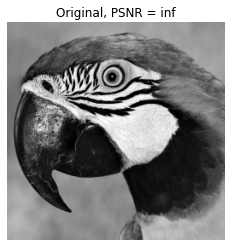

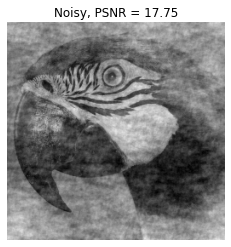

In [2]:
params = create_problem(img_path='./data/Set12/07.png')

psnr_display(img_path='./data/Set12/07.png', output=params['original'], title="Original")

psnr_display(img_path='./data/Set12/07.png', output=params['noisy'], title="Noisy")

In [ ]:
# '''
# cross validation testing
# '''
# # def f(iters):
# #     return peak_signal_noise_ratio(params['original'], pnp_svrg(params=params,
# #                                                                 denoiser='cnn',
# #                                                                 eta=iters[0], T1=iters[1], T2=iters[2], 
# #                                                                 mini_batch_size=iters[3])[0])

# # with MP.Pool(processes=5) as pool:
# #     results = list(tqdm.tqdm(pool.imap(f, iters), total=len(iters)))
    
# # max(results), iters[results.index(max(results))]


# # T1 = list(np.arange(0, 4, 1)[1:])
# T2 = list(np.arange(3, 8, 1)[1:])
# eta = list(np.arange(15e3, 40e3, 1e3))
# # batch = list(map(int, np.arange(25e3, 35e3, 5e3)))
# iters = list(product(eta, T2))

# results = []

# params = create_problem('./data/Set12/07.png', device='cuda')

# for t2 in tqdm.tqdm(T2):
#     results.append((peak_signal_noise_ratio(params['original'], pnp_svrg(params=params,
#                                                                 denoiser='cnn',
#                                                                 eta=20e3, tt=5, T2=t2, 
#                                                                 mini_batch_size=int(20e3),
#                                                                 verbose=False)[0]), 
#                                                                 e, t2))
# results = sorted(results, reverse=True)

After gradient update: 0 0 19.137711548640876
After denoising update: 0 0 17.69498612074539

After gradient update: 0 1 19.92875488609558
After denoising update: 0 1 19.45120346602298

After gradient update: 0 2 20.707868684214446
After denoising update: 0 2 19.625732074606717

After gradient update: 0 3 21.283021363944105
After denoising update: 0 3 20.542038753651436

After gradient update: 0 4 21.773314926368666
After denoising update: 0 4 20.951456033918895

After gradient update: 0 5 22.306319795964257
After denoising update: 0 5 21.524718289789245

After gradient update: 0 6 22.74763076516665
After denoising update: 0 6 22.055430489763737

After gradient update: 0 7 23.134515682607784
After denoising update: 0 7 22.390565397159147

After gradient update: 0 8 23.606429198711755
After denoising update: 0 8 22.86336483979379

After gradient update: 0 9 23.685029822171636
After denoising update: 0 9 23.063857247656955

After gradient update: 1 0 24.340351898570702
After denoising upd

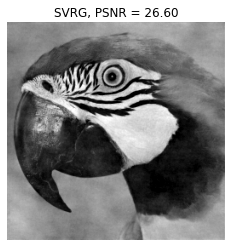

In [12]:
params = create_problem(img_path='./data/Set12/07.png', device=device, cnn_decay=0.90)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_svrg(params=params,
                                                   denoiser='cnn',
                                                   eta=20e3, tt=20, T2=10, 
                                                   mini_batch_size=int(20e3))

psnr_display(img_path='./data/Set12/07.png', output=svrg_out, title="SVRG")

In [ ]:
gif(svrg_zs)

0 19.21852030349432
1 20.949070671590917
2 21.62784950949531
3 22.40353374629143
4 22.88259080858137
5 23.43046329672774
6 23.85721606304912
7 24.26309453191395
8 24.61126569654413
9 24.928895352906693
10 25.212438183891173
11 25.467723429114027
12 25.6964735108861
13 25.90047062025358
14 26.081907866074594
15 26.24260332101263
16 26.38464799902359
17 26.50990125498259
18 26.620006180295817
19 26.716464219283232
20 26.800753501239328
21 26.87418341574076
22 26.93800790590876
23 26.993375517783257
24 27.04134301553577
25 27.082867001654705
26 27.118793392745197
27 27.149861622690302
28 27.1767384338597
29 27.200004342553598
30 27.220161682328335
31 27.237644608949868
32 27.252827025710737
33 27.26602827451432
34 27.27752199009562
35 27.28754270091944
36 27.29629286188278
37 27.30394517633451
38 27.31064801049594
39 27.31652860321943
40 27.321695968567255
41 27.32624377044136


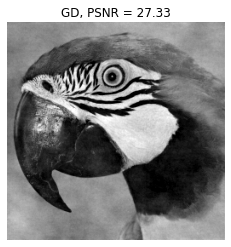

In [13]:
params = create_problem('./data/Set12/07.png', device=device)

gd_out, gd_time, gd_psnr, gd_zs = pnp_gd(params=params,
                                         denoiser='cnn',
                                         eta=40e3, tt=20)

psnr_display(img_path='./data/Set12/07.png', output=gd_out, title="GD")

0 17.388225587223957
1 19.030842774392674
2 19.72043056795089
3 20.786327968080673
4 21.339743712174744
5 21.97484506668639
6 22.280045955243608
7 22.737804850043165
8 23.042413731271772
9 23.326136414125983
10 23.580439355341966
11 23.845191070393774
12 24.100131164625758
13 24.323169861889657
14 24.55089539873044
15 24.75696782724041
16 24.951295283034057
17 25.12014492604913
18 25.290824197879594
19 25.448398237712865
20 25.588838759600332
21 25.7308502371111
22 25.855638571174477
23 25.968266822674536
24 26.06899833610957
25 26.155031846724484
26 26.24162529500118
27 26.314986208317638
28 26.37387423669707
29 26.433382427425883
30 26.48186100473169
31 26.528271114317036
32 26.566980362577123
33 26.600833383659875
34 26.631896386839145
35 26.65746863800376
36 26.680002708452925
37 26.700945566013623
38 26.71867361354002
39 26.733518583469312
40 26.746980599015295
41 26.75905296960652
42 26.768722665273312
43 26.777528716430385
44 26.785094928949498
45 26.791870021335676
46 26.797804

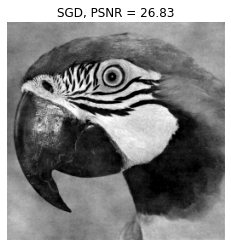

In [14]:
params = create_problem('./data/Set12/07.png', device=device)

sgd_out, sgd_time, sgd_psnr, sgd_zs = pnp_sgd(params=params,
                                              denoiser='cnn',
                                              eta=20e3, tt=20, 
                                              mini_batch_size=int(20e3))

psnr_display(img_path='./data/Set12/07.png', output=sgd_out, title="SGD")

0 17.69498612074539
1 19.568183981326428
2 19.67328261772289
3 20.847474474323384
4 21.23293864260838
5 21.810893049326832
6 22.235960335713575
7 22.571412474013627
8 22.877393759489657
9 23.264650904155104
10 23.572569233822087
11 23.843708049369027
12 24.10551611651829
13 24.36853270005177
14 24.602898142013938
15 24.81996035712551
16 25.020158241892215
17 25.20569057929745
18 25.37409678103781
19 25.533958833123606
20 25.684569583757057
21 25.819383877023988
22 25.939941583570786
23 26.047582808040808
24 26.145065913017365
25 26.232647031741067
26 26.315662673547283
27 26.3862734178146
28 26.44864059291521


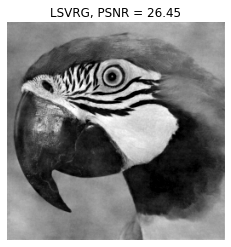

In [15]:
params = create_problem('./data/Set12/07.png', device=device)

lsvrg_out, lsvrg_time, lsvrg_psnr, lsvrg_zs = pnp_lsvrg(params=params,
                                                denoiser='cnn',
                                                eta=20e3, tt=20, 
                                                mini_batch_size=int(20e3))

psnr_display(img_path='./data/Set12/07.png', output=lsvrg_out, title="LSVRG")

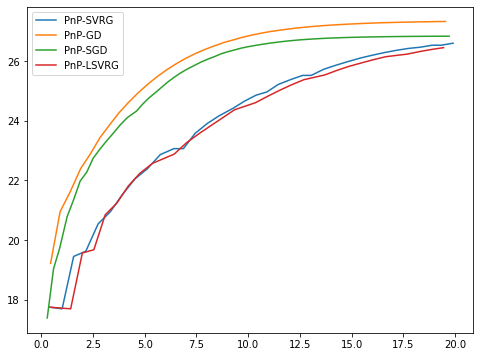

In [16]:
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

psnr_ax.plot(np.cumsum(svrg_time), svrg_psnr, label='PnP-SVRG')
psnr_ax.plot(np.cumsum(gd_time), gd_psnr, label='PnP-GD')
psnr_ax.plot(np.cumsum(sgd_time), sgd_psnr, label='PnP-SGD')
psnr_ax.plot(np.cumsum(lsvrg_time), lsvrg_psnr, label='PnP-LSVRG')
psnr_ax.legend()

In [ ]:
original, noisy, denoised = denoise_rgb(img_path='./flickr30k/train/398662202.jpg')

In [ ]:
psnr_display(img=original, output=original, title="Original")

In [ ]:
psnr_display(img=original, output=noisy, title="Noisy")

In [ ]:
psnr_display(img=original, output=denoised, title="Denoised")